In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import os
import imageio
import seaborn as sns
import warnings
import sympy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,6)},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")
warnings.filterwarnings("default")

/Users/cygnari/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
llns = np.loadtxt(f'LLNsnew.dat', unpack=True)[1:4,] # column 0 is h', column 1 is l', column 2 is k'

In [4]:
h1 = llns[1, 0]
l1 = llns[1, 1]
k1 = llns[1, 2]

llns[1, 0] = 2 / 3 * (h1 - l1)
llns[1, 1] = -1 / 3 * (h1 - l1)
llns[1, 2] = -1 / 3 * h1 - 2 / 3 * l1 - 1

In [5]:
rho = 1035 # density of seawater is on average 1035 kg/m^3
rhoe = 5517 # density of earth is on average 5517 kg/m^3
earthradius = 6371000 # radius of earth in meters

In [6]:
def alpha(n):
    return 3 * rho * (1 + llns[2, n] - llns[0, n]) / (rhoe * (2 * n + 1))

In [7]:
def gfsphcoeff(n):
    return alpha(n) * np.sqrt((2 * n + 1) / (4 * math.pi))

In [8]:
def greenfunc(phid, thetad, phi, theta, stop):
    out = np.zeros((stop,) + np.shape(phid))
    for n in range(stop): 
        newpart = gfsphcoeff(n) * sp.special.sph_harm(0, n, theta - thetad, phi - phid)
        out[n] = np.real(newpart)
    
    return out

In [9]:
def greenfuncsum(phid, thetad, phi, theta, stop):
    vals = greenfunc(phid, thetad, phi, theta, stop)
    return np.sum(vals, axis=0)

In [284]:
def cesgfsum(phid, thetad, phi, theta, stop):
    vals = greenfunc(phid, thetad, phi, theta, stop)
    weights = 1 - np.mgrid[0:1:1/stop]
    return np.sum(vals * np.transpose(np.tile(weights, (18000, 1))), axis=0)

In [282]:
latvals = np.deg2rad(np.mgrid[0:180:0.01])
response = greenfuncsum(latvals, 0, 0, 0, 525)
polyfit = np.polynomial.polynomial.Polynomial.fit(latvals, response, 30, domain=[0, math.pi])

In [285]:
latvals = np.deg2rad(np.mgrid[0:180:0.01])
cesresponse = cesgfsum(latvals, 0, 0, 0, 1000)
cespolyfit = np.polynomial.polynomial.Polynomial.fit(latvals, cesresponse, 30, domain=[0, math.pi])

In [291]:
cesinterpfunc = sp.interpolate.interp1d(latvals, cesresponse, kind='cubic', fill_value='extrapolate') # cubic spline fit
interpfunc = sp.interpolate.interp1d(latvals, response, kind='cubic', fill_value='extrapolate') # cubic spline fit

In [257]:
def rationalfit(x, params):
#     return params[0] / (np.power(x, params[1]) + params[2]) + params[3] + params[4] * x / (np.power(x, params[5]) + params[6])
    return params[0] / (np.power(x, 1) + params[1]) + params[2] / (np.power(x, 2) + params[3]) + params[4]

In [372]:
def absfitfunc(x):
    return np.linalg.norm(np.where(latvals < 0.1, response - rationalfit(latvals, x), 0))

In [72]:
def relfitfunc(x):
    return np.linalg.norm((rationalfit(latvals, x) - response) / response)

In [223]:
def gaufit(x, params):
    return params[0] * np.exp(-np.square(params[1] * x)) + params[2]

In [413]:
def gaufitfunc(x):
    return np.linalg.norm(np.where(latvals < 0.2, response - gaufit(latvals, x), 0))

In [340]:
def expfit(x, params):
    return params[0] * np.exp(params[1] * x) + params[2]

In [378]:
def expfitfunc(params):
    return np.linalg.norm(np.where(latvals > 0.2, expfit(latvals, params) - response, 0))

In [456]:
def actualfitfunc(x):
    scaling = np.power(1 - x / math.pi, 30)
    scaling2 = 25 * x * np.exp(- 1 / 0.04 * x)
    return gaufit(x, gauresult.x) * (scaling) + (1 - scaling - scaling2) * expfit(x, expresult.x) + scaling2 * rationalfit(x, absresult.x)

In [414]:
absresult = sp.optimize.minimize(absfitfunc, [0.0275, 1, 0.005, 1, 0.005], bounds=[(None, None), (1e-5, None), (None, None), (1e-5, None), (None, None)],method='Nelder-Mead')
# relresult = sp.optimize.minimize(relfitfunc, [0.0275, 1, 0.005, 1, 0.005, 2, 2], bounds=[(None, None), (1e-5, None), (None, None), (1e-5, None), (None, None)],method='Nelder-Mead')
gauresult = sp.optimize.minimize(gaufitfunc, [1, 1, 1], bounds=[(0, None), (None, None), (None, None)],method='Nelder-Mead')
expresult = sp.optimize.minimize(expfitfunc, [1, -1, 1], bounds=[(0, None), (None, 0), (None, None)],method='Nelder-Mead')

In [354]:
expresult

 final_simplex: (array([[ 1.28845784e+00, -1.59563838e+02,  1.34732166e-02],
       [ 1.28845779e+00, -1.59563768e+02,  1.34734151e-02],
       [ 1.28845800e+00, -1.59563873e+02,  1.34722199e-02],
       [ 1.28845880e+00, -1.59563933e+02,  1.34717410e-02]]), array([12.28189841, 12.28189841, 12.28189841, 12.28189841]))
           fun: 12.281898412368022
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 62
        status: 0
       success: True
             x: array([ 1.28845784e+00, -1.59563838e+02,  1.34732166e-02])

In [154]:
def linfit(x, params):
    return np.where(x < 0.01, params[0] * x + params[1], params[2] * x + params[3])

In [124]:
def linfitfunc(params):
    return np.linalg.norm((response-linfit(latvals, params)) / response)

In [144]:
# linresult = sp.optimize.minimize(linfitfunc, [-100, 150, -1, 0.005], bounds=[(None, 0), (0, None), (None, 0), (0, None)], method='Nelder-Mead')

In [173]:
absresult.x

array([ 2.69485301e-01,  2.19028333e-03,  8.36072664e-03,  1.11864083e+00,
       -1.83028294e-02, -9.76850302e+00, -8.66668912e+00])

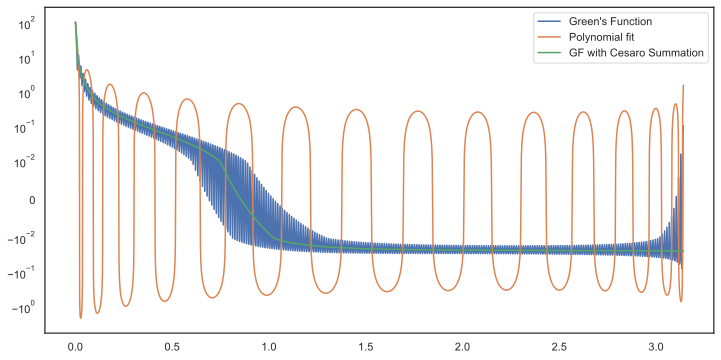

In [461]:
plt.plot(latvals, response, label="Green's Function")
plt.plot(latvals, polyfit(latvals), label='Polynomial fit')
plt.plot(latvals, cesresponse, label="GF with Cesaro Summation")
# plt.plot(latvals, rationalfit(latvals, absresult.x), label="Absolute function fit")
# plt.plot(latvals, rationalfit(latvals, relresult.x), label="Relative function fit")
# plt.plot(latvals, actualfitfunc(latvals), label="Mixed function fit")
# plt.plot(latvals, linfit(latvals, [-5000, 150, -0.0001, -0.02]), label="PC lin fit")
# plt.plot(latvals, interpfunc(latvals), label='Spline interp')
# plt.plot(latvals, cespolyfit(latvals), label="Ces Sum Poly Fit")
# plt.plot(latvals, polyfit(latvals), label="Poly Fit")
# plt.plot(latvals, gaufit(latvals, gauresult.x), label="Gaussian Fit")
# plt.plot(latvals, expfit(latvals, expresult.x), label="Exponential Fit")
# plt.xlim(1e-6, math.pi+1e-2)
# plt.xlim(-1e-3, 0.2)
# plt.title("Green's Function and Polynomial Fit")
plt.yscale('symlog', linthresh=1e-2)
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-20, 6)
# 
plt.legend()
plt.show()

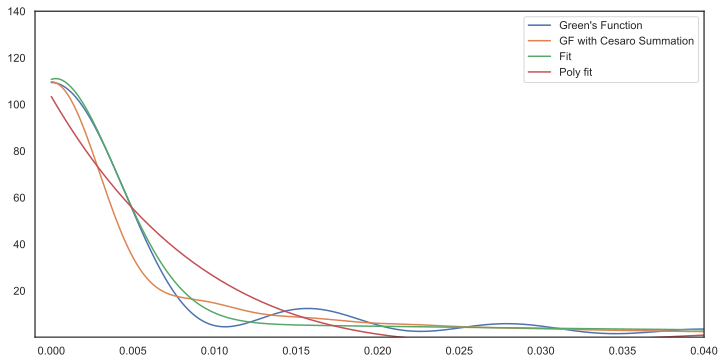

In [464]:
plt.plot(latvals, response, label="Green's Function")
plt.plot(latvals, cesresponse, label="GF with Cesaro Summation")
plt.plot(latvals, actualfitfunc(latvals), label="Fit")
plt.plot(latvals, polyfit(latvals), label="Poly fit")
# plt.plot(latvals, gaufit(latvals, gauresult.x) * response[0] / gaufit(0, gauresult.x), label="Gaussian function fit")

# plt.plot(latvals, expfit(latvals, expresult.x), label="Exponential function fit")
# plt.yscale('symlog', linthresh=1e-2)
plt.xlim(-1e-3, 0.04)
plt.ylim(0.1, 140)
# plt.yscale('log')
plt.legend()
plt.show()

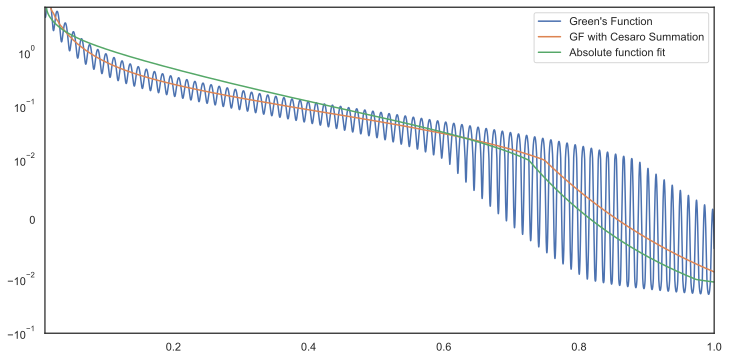

In [410]:
plt.plot(latvals, response, label="Green's Function")
plt.plot(latvals, cesresponse, label="GF with Cesaro Summation")
plt.plot(latvals, actualfitfunc(latvals), label="Absolute function fit")
plt.yscale('symlog', linthresh=1e-2)
plt.ylim(-0.1, 7)
plt.xlim(0.02-1e-2, 1)
plt.legend()
plt.show()

In [327]:
actualfitfunc(latvals[1]) - response[1]

1.245890553555796

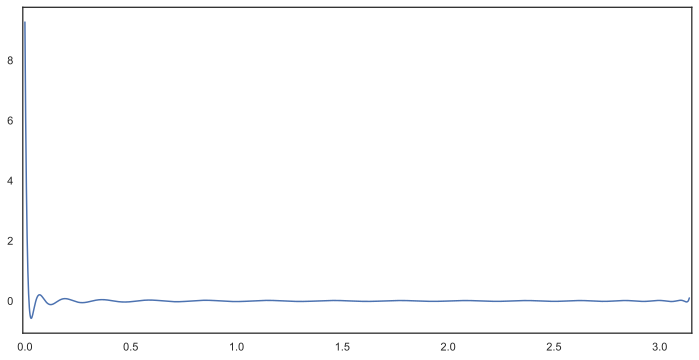

In [70]:
plt.plot(latvals, polyfit(latvals) - cespolyfit(latvals))
plt.xlim(-1e-2, math.pi+1e-2)
plt.show()

In [22]:
def gcdists(lons, lats, pointlon, pointlat): # great circle distance to (pointlon, pointlat) on earth
    lats = math.pi / 2 - lats
    pointlat = math.pi / 2 - pointlat
    return np.arccos(np.maximum(np.minimum(np.sin(pointlat) * np.sin(lats) + np.cos(pointlat) * np.cos(lats) * np.cos((lons - pointlon)), 1), -1))

In [23]:
def salpotential(lons, lats, areas, ssh, greenfunc, lonvals, latvals):
    salpot = np.zeros(np.shape(areas))
    for i in range(len(lonvals)):
        for j in range(len(latvals)):
            distances = gcdists(lons, lats, lonvals[i], latvals[j])
            salpot[i, j] = np.sum(greenfunc(distances) * ssh * areas)
    
    return salpot

In [24]:
def amplitudeerrors(dlat, dlon, n, m, func):
    latvals = np.deg2rad(np.mgrid[0:180:dlat])
    lonvals = np.deg2rad(np.mgrid[0:360:dlon])
    lats, lons = np.meshgrid(latvals, lonvals)
    areas = np.zeros(np.shape(lons))
    
    for i in range(len(latvals)):
        for j in range(len(lonvals)):
            areas[j, i] = np.sin(latvals[i]) * (latvals[1] - latvals[0]) * (lonvals[1] - lonvals[0])
#             areas[j, i] = np.sin(latvals[i])
            
#     response = greenfuncsum(latvals, 0, 0, 0, 200) 
#     polyfit = np.polynomial.polynomial.Polynomial.fit(latvals, response, 30, domain=[0, math.pi])
    ssh = np.real(sp.special.sph_harm(m, n, lons, lats))
    test = salpotential(lons, lats, areas, ssh, func, lonvals, latvals) 
    realresponse = alpha(n) * ssh
    return (test / realresponse)[0,:], latvals
#     return lats, lons, test

In [27]:
error1, lats1 = amplitudeerrors(1, 1, 3, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [28]:
error2, lats2 = amplitudeerrors(0.5, 0.5, 3, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [29]:
error3, lats3 = amplitudeerrors(2, 2, 3, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [30]:
error4, lats4 = amplitudeerrors(3, 3, 3, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


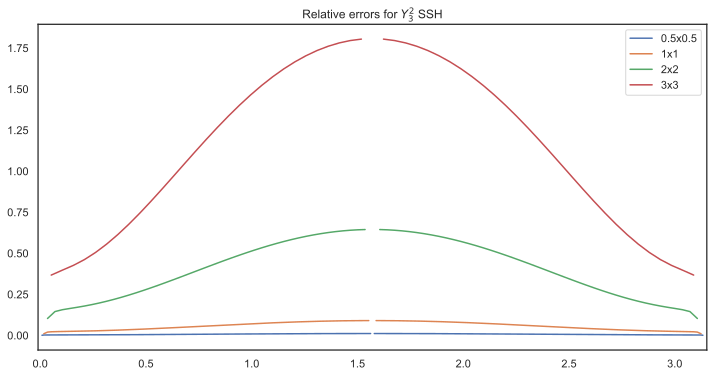

In [459]:
plt.plot(lats2, error2-1, label='0.5x0.5')
plt.plot(lats1, error1-1, label='1x1')
plt.plot(lats3, error3-1, label='2x2')
plt.plot(lats4, error4-1, label='3x3')
plt.legend()
plt.xlim(-1e-2, math.pi+1e-2)
# plt.yscale('symlog', linthresh=1e-2)
# plt.yscale('log')
plt.title(r'Relative errors for $Y_3^2$ SSH')
plt.show()

In [33]:
error2[89]-1

0.00718383180310922

In [32]:
error21, lats21 = amplitudeerrors(1, 1, 5, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [34]:
error22, lats22 = amplitudeerrors(2, 2, 5, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [35]:
error23, lats23 = amplitudeerrors(3, 3, 5, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [36]:
error24, lats24 = amplitudeerrors(0.5, 0.5, 5, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


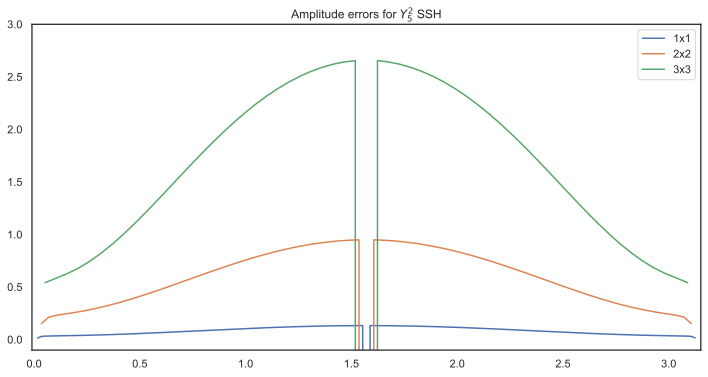

In [59]:
# plt.plot(lats24, error24-1, label='0.5x0.5')
plt.plot(lats21, error21-1, label='1x1')
plt.plot(lats22, error22-1, label='2x2')
plt.plot(lats23, error23-1, label='3x3')
plt.legend()
plt.xlim(-1e-2, math.pi+1e-2)
plt.ylim(-0.1, 3)
# plt.yscale('log')
plt.title(r'Amplitude errors for $Y_5^2$ SSH')
plt.show()

In [38]:
error24[45]-1

0.006250357413030594

In [39]:
errorcp32, latscp32 = amplitudeerrors(1, 1, 3, 2, cespolyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [40]:
errorcp52, latscp52 = amplitudeerrors(1, 1, 5, 2, cespolyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [41]:
errorp32, latsp32 = amplitudeerrors(1, 1, 3, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [42]:
errorp52, latsp52 = amplitudeerrors(1, 1, 5, 2, polyfit)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [43]:
errorpi52, latspi52 = amplitudeerrors(1, 1, 5, 2, interpfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [44]:
errorpi32, latspi32 = amplitudeerrors(1, 1, 3, 2, interpfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [45]:
errorpci52, latspci52 = amplitudeerrors(1, 1, 5, 2, cesinterpfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [46]:
errorpci32, latspci32 = amplitudeerrors(1, 1, 3, 2, cesinterpfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


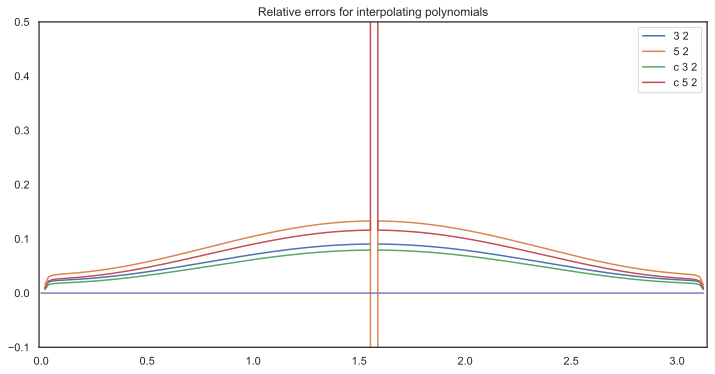

In [51]:
plt.plot(latsp32, errorp32-1, label='3 2')
plt.plot(latsp52, errorp52-1, label='5 2')
plt.plot(latscp32, errorcp32-1, label='c 3 2')
plt.plot(latscp52, errorcp52-1, label='c 5 2')
plt.plot(latsp32, np.zeros(len(latsp32)))
plt.legend()
plt.xlim(-1e-2, math.pi)
plt.ylim(-0.1, 0.5)
# plt.yscale('log')
plt.title('Relative errors for interpolating polynomials')
plt.show()

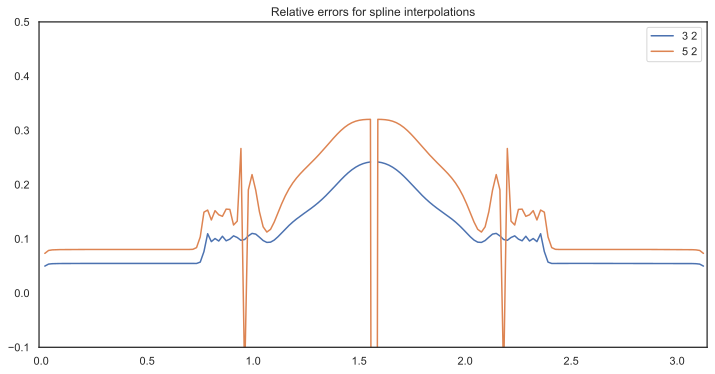

In [465]:
plt.plot(latsp32, errorpi32-1, label='3 2')
plt.plot(latsp52, errorpi52-1, label='5 2')
# plt.plot(latscp32, errorpci32-1, label='c 3 2')
# plt.plot(latscp52, errorpci52-1, label='c 5 2')
# plt.plot(latsp32, np.zeros(len(latsp32)))
plt.legend()
plt.xlim(-1e-2, math.pi)
plt.ylim(-0.1, 0.5)
# plt.yscale('log')
plt.title('Relative errors for spline interpolations')
plt.show()

In [195]:
errorpr32, latspr32 = amplitudeerrors(1, 1, 3, 2, actualfitfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [196]:
errorpr32a, latspr32a = amplitudeerrors(0.5, 0.5, 3, 2, actualfitfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [434]:
errorpr32b, latspr32b = amplitudeerrors(2, 2, 3, 2, actualfitfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [438]:
errorpr52, latspr52 = amplitudeerrors(1, 1, 5, 2, actualfitfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [439]:
errorpr52a, latspr52a = amplitudeerrors(2, 2, 5, 2, actualfitfunc)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


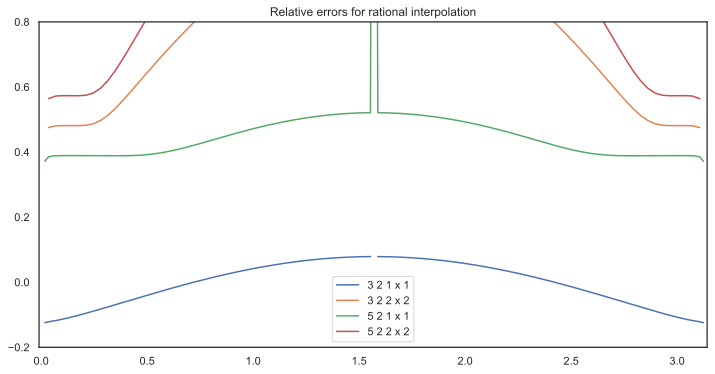

In [460]:
# plt.plot(latspr32a, errorpr32a, label='0.5 x 0.5')
plt.plot(latspr32, errorpr32-1, label='3 2 1 x 1')
plt.plot(latspr32b, errorpr32b-1, label='3 2 2 x 2')
plt.plot(latspr52, errorpr52-1, label='5 2 1 x 1')
plt.plot(latspr52a, errorpr52a-1, label='5 2 2 x 2')
# plt.plot(latspr52, errorpr52-1, label='5 2')
# plt.plot(latscp32, errorpci32-1, label='c 3 2')
# plt.plot(latscp52, errorpci52-1, label='c 5 2')
# plt.plot(latsp32, np.zeros(len(latsp32)))
plt.legend()
plt.xlim(-1e-2, math.pi)
plt.ylim(-0.2, 0.8)
# plt.yscale('log')
plt.title('Relative errors for rational interpolation')
plt.show()

In [477]:
degs = np.mgrid[1:31:1]
errors1 = np.zeros(len(degs))
errors2 = np.zeros(len(degs))

for i in range(len(degs)):
    poly = np.polynomial.polynomial.Polynomial.fit(latvals, response, degs[i], domain=[0, math.pi])
    temperror, templats = amplitudeerrors(1, 1, 3, 2, poly)
    errors1[i] = np.linalg.norm(np.nan_to_num(temperror-1, nan=0, posinf=0, neginf=0))
    temperror, templats = amplitudeerrors(2, 2, 3, 2, poly)
    errors2[i] = np.linalg.norm(np.nan_to_num(temperror-1, nan=0, posinf=0, neginf=0))

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_3439/1934295941.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


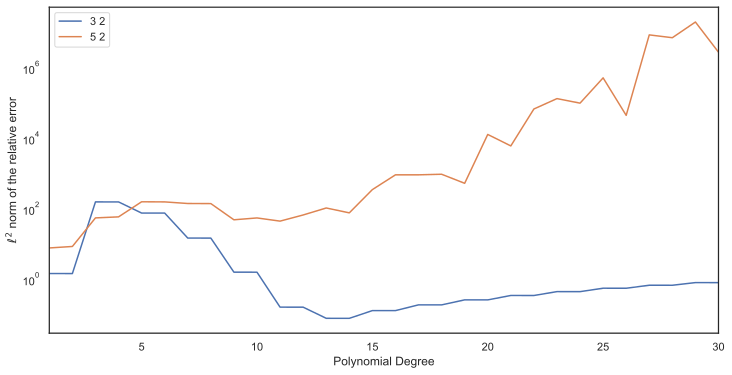

In [479]:
plt.plot(degs, errors1, label='1 x 1')
plt.plot(degs, errors2, label='2 x 2')
plt.yscale('log')
plt.xlim(1, 30)
plt.xlabel('Polynomial Degree')
plt.ylabel(r'$\ell^2$ norm of the relative error')
plt.legend()
plt.show()